<a href="https://colab.research.google.com/github/amanzoni1/MoE-Burst-Upcycling/blob/main/HELLoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Uninstall the conflicting library
!pip uninstall -y torchvision

# 2. Force install the bleeding-edge Transformers (fixes the missing OLMoE class)
!pip install -U git+https://github.com/huggingface/transformers

# 3. Install core dependencies
!pip install -U torch accelerate peft datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-2126y2x2
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-2126y2x2
  Resolved https://github.com/huggingface/transformers to commit c8561da82c42adca9325f01ce1ff5aabadea0c3f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import torch
from transformers import OlmoeForCausalLM, AutoTokenizer

model_name = "allenai/OLMoE-1B-7B-0924"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = OlmoeForCausalLM.from_pretrained(
    model_name,
    dtype=torch.bfloat16,
    device_map="auto",
)

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/179 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

In [6]:
print("\n=== 🔍 MODEL ARCHITECTURE DIG ===")
print(f"Model Class: {type(model).__name__}")

# We only care about the decoder layers where the MoE lives
# Usually found in model.model.layers or model.layers
layers = model.model.layers

print(f"Total Layers: {len(layers)}")

# Let's inspect Layer 0 specifically to find the Router and Experts
layer_0 = layers[0]
print("\n=== 🔬 INSIDE LAYER 0 ===")
for name, module in layer_0.named_modules():
    # Only print top-level components of the layer
    if name.count(".") == 0 and name != "":
        print(f" • {name}: {module.__class__.__name__}")

        # If this is the MoE block, dig deeper
        if "moe" in name.lower():
            print(f"    └── Found MoE Block! Digging deeper...")
            for sub_name, sub_module in module.named_modules():
                if sub_name == "gate":
                    print(f"        👉 ROUTER found: '{name}.{sub_name}' -> {sub_module}")
                if "experts" in sub_name and sub_name.count(".") == 0:
                     print(f"        👉 EXPERTS container: '{name}.{sub_name}' -> Contains {len(sub_module)} experts")


=== 🔍 MODEL ARCHITECTURE DIG ===
Model Class: OlmoeForCausalLM
Total Layers: 16

=== 🔬 INSIDE LAYER 0 ===
 • self_attn: OlmoeAttention
 • mlp: OlmoeSparseMoeBlock
 • input_layernorm: OlmoeRMSNorm
 • post_attention_layernorm: OlmoeRMSNorm


In [5]:
print("\n" + "="*50)
print(f"🏗️  DEEP DIVE: {model_name}")
print("="*50)

# Recursive function to print structure with indent
def print_structure(module, indent=0):
    for name, child in module.named_children():
        prefix = "  " * indent
        print(f"{prefix}├── \033[1m{name}\033[0m: {child.__class__.__name__}")

        # Dig deeper if it's a container or MoE layer
        if list(child.named_children()):
            print_structure(child, indent + 1)

# Start digging from the main model block
# We usually skip the outer 'model' wrapper to save space
print_structure(model)

print("\n" + "="*50)
print("🧐 INSPECTING SPECIFIC PARAMETERS")
print("="*50)

# Let's verify the exact path to the router
found_router = False
for name, module in model.named_modules():
    if "gate" in name or "router" in name:
        print(f"✅ Found potential Router: \033[92m{name}\033[0m")
        print(f"   Type: {module}")
        found_router = True

if not found_router:
    print("❌ Could not auto-detect router name. Check the tree above manually.")


🏗️  DEEP DIVE: allenai/OLMoE-1B-7B-0924
├── model: OlmoeModel
  ├── embed_tokens: Embedding
  ├── layers: ModuleList
    ├── 0: OlmoeDecoderLayer
      ├── self_attn: OlmoeAttention
        ├── q_proj: Linear
        ├── k_proj: Linear
        ├── v_proj: Linear
        ├── o_proj: Linear
        ├── q_norm: OlmoeRMSNorm
        ├── k_norm: OlmoeRMSNorm
      ├── mlp: OlmoeSparseMoeBlock
        ├── gate: OlmoeTopKRouter
        ├── experts: OlmoeExperts
          ├── act_fn: SiLUActivation
      ├── input_layernorm: OlmoeRMSNorm
      ├── post_attention_layernorm: OlmoeRMSNorm
    ├── 1: OlmoeDecoderLayer
      ├── self_attn: OlmoeAttention
        ├── q_proj: Linear
        ├── k_proj: Linear
        ├── v_proj: Linear
        ├── o_proj: Linear
        ├── q_norm: OlmoeRMSNorm
        ├── k_norm: OlmoeRMSNorm
      ├── mlp: OlmoeSparseMoeBlock
        ├── gate: OlmoeTopKRouter
        ├── experts: OlmoeExperts
          ├── act_fn: SiLUActivation
      ├── input_layernorm: OlmoeRMS

In [11]:
import torch
from collections import defaultdict

# 1. SETUP: Define the hook mechanism
# We will store how many times each expert is selected
# { layer_idx: { expert_idx: count } }
activation_counts = defaultdict(lambda: torch.zeros(64, device="cuda"))

def get_router_hook(layer_idx):
    def hook(module, input, output):
        # --- PROBE (DEBUGGING) ---
        # The first time this runs, we print what the output looks like
        # so we are 100% sure we are grabbing the right thing.
        if layer_idx == 0 and activation_counts[0].sum() == 0:
            print(f"\n🕵️ PROBE - Layer {layer_idx} Gate Output Type: {type(output)}")
            if isinstance(output, tuple):
                print(f"   It's a tuple! Length: {len(output)}")
                print(f"   Item 0 shape: {output[0].shape}")
            else:
                print(f"   Shape: {output.shape}")

        # --- THE LOGIC ---
        # OLMoE's router usually outputs 'router_logits' of shape [batch*seq_len, num_experts]
        # We need to calculate which ones are the Top-8 (active ones)

        router_logits = output

        # Handle if it's a tuple (logits usually come first)
        if isinstance(output, tuple):
            router_logits = output[0] # Usually [batch, seq_len, num_experts]

        # Reshape to [total_tokens, num_experts]
        if len(router_logits.shape) == 3:
            router_logits = router_logits.view(-1, router_logits.shape[-1])

        # Find Top-8 Experts (OLMoE standard)
        # We don't care about the values, just the indices
        _, selected_indices = torch.topk(router_logits, k=8, dim=-1)

        # Flatten to a simple list of "all experts selected in this batch"
        indices_flat = selected_indices.flatten()

        # Count them efficiently on GPU
        counts = torch.bincount(indices_flat, minlength=64)
        activation_counts[layer_idx] += counts

    return hook

# 2. ATTACH: Hook every layer
print("🪝 Attaching hooks to model.layers...mlp.gate")
hooks = []
for i, layer in enumerate(model.model.layers):
    # Use the path YOU found: mlp.gate
    h = layer.mlp.gate.register_forward_hook(get_router_hook(i))
    hooks.append(h)

print(f"✅ Attached {len(hooks)} hooks.")

# 3. RUN: Pass some dummy data (or your real data)
# Since we don't have your dataset yet, I'll use a generic sentence to test.
print("\n🚀 Running Forward Pass...")
dummy_text = "The quick brown fox jumps over the lazy dog. " * 10
inputs = tokenizer(dummy_text, return_tensors="pt").to("cuda")

with torch.no_grad():
    _ = model(**inputs)

# 4. REPORT: Who are the "Hot" Experts?
print("\n" + "="*40)
print("🔥 HOT EXPERTS REPORT (Top 3 per layer)")
print("="*40)

hot_experts_map = {} # We save this for the next step

for layer_idx in range(16): # 16 layers
    counts = activation_counts[layer_idx]

    # Get indices of the experts with highest counts
    top_k_indices = torch.topk(counts, k=3).indices.tolist()

    # Calculate usage % (just for your info)
    total_calls = counts.sum().item()
    top_usage = counts[top_k_indices[0]].item()
    percentage = (top_usage / total_calls) * 100 if total_calls > 0 else 0

    print(f"Layer {layer_idx:02d}: Experts {top_k_indices} (Top 1 used {percentage:.1f}%)")

    # Save for HELLoRA config later
    hot_experts_map[layer_idx] = top_k_indices

# 5. CLEANUP: Remove hooks so they don't slow down future runs
for h in hooks:
    h.remove()
print("\n🧹 Hooks removed.")

🪝 Attaching hooks to model.layers...mlp.gate
✅ Attached 16 hooks.

🚀 Running Forward Pass...

🕵️ PROBE - Layer 0 Gate Output Type: <class 'tuple'>
   It's a tuple! Length: 3
   Item 0 shape: torch.Size([101, 64])

🔥 HOT EXPERTS REPORT (Top 3 per layer)
Layer 00: Experts [6, 41, 42] (Top 1 used 7.7%)
Layer 01: Experts [5, 37, 9] (Top 1 used 8.8%)
Layer 02: Experts [5, 38, 48] (Top 1 used 7.9%)
Layer 03: Experts [61, 31, 10] (Top 1 used 9.4%)
Layer 04: Experts [43, 63, 39] (Top 1 used 9.4%)
Layer 05: Experts [0, 37, 60] (Top 1 used 8.8%)
Layer 06: Experts [57, 10, 31] (Top 1 used 11.1%)
Layer 07: Experts [4, 0, 35] (Top 1 used 10.9%)
Layer 08: Experts [27, 51, 6] (Top 1 used 10.9%)
Layer 09: Experts [51, 9, 14] (Top 1 used 10.5%)
Layer 10: Experts [22, 20, 44] (Top 1 used 11.0%)
Layer 11: Experts [47, 7, 14] (Top 1 used 11.0%)
Layer 12: Experts [32, 45, 26] (Top 1 used 8.8%)
Layer 13: Experts [59, 16, 39] (Top 1 used 10.8%)
Layer 14: Experts [4, 17, 35] (Top 1 used 11.3%)
Layer 15: Exper

In [10]:
import torch
import os

# Global Configuration
CONFIG = {
    "batch_size": 32,
    "seq_len": 2048,
    "seed": 123,
    "output_dir": "./telemetry"
}

# Dataset Registry
DATASETS = {
    "gsm8k": {
        "path": "gsm8k",
        "name": "main",
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: f"Question: {item['question']}\nAnswer: {item['answer']}"
    },
    "wikitext": {
        "path": "wikitext",
        "name": "wikitext-2-raw-v1",
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: item['text']
    },
    "code_alpaca": {
        "path": "sahil2801/CodeAlpaca-20k",
        "name": None,
        "split": "train",
        "num_samples": 1000,
        "text_fn": lambda item: f"{item['instruction']}\n{item['input']}\n{item['output']}"
    }
}

In [4]:
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import os

class ProfilerEngine:
    def __init__(self, model, tokenizer, output_dir):
        self.model = model
        self.tokenizer = tokenizer
        self.output_dir = output_dir

        # Dynamic architecture detection
        if hasattr(model, "model") and hasattr(model.model, "layers"):
            self.layers = model.model.layers
        elif hasattr(model, "layers"): # Fallback for some architectures
            self.layers = model.layers
        else:
            raise ValueError("Could not automatically identify model layers.")

        self.num_layers = len(self.layers)
        self.hooks = []
        self.data_buffer = {}

        # Create output dir if not exists
        os.makedirs(self.output_dir, exist_ok=True)

    def _get_hook(self, layer_idx):
        """Closure for capturing telemetry."""
        def hook(module, input, output):
            # Extract logits (support tuple output)
            logits = output[0] if isinstance(output, tuple) else output

            # Flatten [Batch, Seq, Experts] -> [Total_Tokens, Experts]
            logits = logits.view(-1, logits.shape[-1])

            # Top-K Indices
            _, indices = torch.topk(logits, k=8, dim=-1)

            # CPU Offload & Storage
            counts = torch.bincount(indices.flatten(), minlength=64).cpu()
            total_tokens = indices.numel()

            self.data_buffer[layer_idx]["counts"].append(counts)
            self.data_buffer[layer_idx]["total"].append(total_tokens)

        return hook

    def attach_hooks(self):
        """Registers hooks dynamically based on model depth."""
        self.hooks = []
        self.data_buffer = {i: {"counts": [], "total": []} for i in range(self.num_layers)}

        print(f"[System] Attaching probes to {self.num_layers} layers...")
        for i, layer in enumerate(self.layers):
            # Note: layer.mlp.gate is specific to OLMoE.
            # For other models (Mixtral/Qwen), this path may change (e.g., block_sparse_moe.gate).
            self.hooks.append(layer.mlp.gate.register_forward_hook(self._get_hook(i)))

    def detach_hooks(self):
        for h in self.hooks: h.remove()
        self.hooks = []
        print("[System] Hooks detached.")

    def run_dataset(self, dataset_key):
        """Executes profiling for a single dataset."""
        if dataset_key not in DATASETS:
            raise ValueError(f"Dataset '{dataset_key}' not found in registry.")

        cfg = DATASETS[dataset_key]
        print(f"\n[Profiler] Starting run: {dataset_key.upper()}")
        print(f"           Source: {cfg['path']} | Samples: {cfg['num_samples']}")

        # Load & Prep
        ds = load_dataset(cfg["path"], cfg.get("name"), split=cfg["split"])
        ds = ds.shuffle(seed=CONFIG["seed"]).select(range(cfg["num_samples"]))

        self.attach_hooks()

        batch_text = []
        pbar = tqdm(total=cfg["num_samples"], desc="Processing")

        for item in ds:
            text = cfg["text_fn"](item)
            if len(text) < 10: continue

            batch_text.append(text)

            if len(batch_text) == CONFIG["batch_size"]:
                self._process_batch(batch_text)
                pbar.update(len(batch_text))
                batch_text = []

        if batch_text:
            self._process_batch(batch_text)
            pbar.update(len(batch_text))

        pbar.close()
        self.detach_hooks()
        return self._save(dataset_key)

    def _process_batch(self, batch_text):
        inputs = self.tokenizer(
            batch_text, return_tensors="pt", padding=True, truncation=True,
            max_length=CONFIG["seq_len"]
        ).to(self.model.device)

        with torch.no_grad():
            self.model(**inputs)

    def _save(self, dataset_key):
        filename = os.path.join(self.output_dir, f"olmoe_activations_{dataset_key}.pt")

        final_data = {}
        for layer, data in self.data_buffer.items():
            final_data[layer] = {
                "counts": torch.stack(data["counts"]),
                "total": torch.tensor(data["total"])
            }

        torch.save(final_data, filename)
        print(f"[IO] Telemetry saved: {filename}")
        return filename

In [5]:
def run_profiling(targets):
    """
    Main entry point for profiling.
    Args:
        targets (list): List of dataset keys (e.g., ['gsm8k', 'wikitext'])
    """
    # Initialize Engine
    engine = ProfilerEngine(model, tokenizer, output_dir=CONFIG["output_dir"])

    generated_files = []

    for target in targets:
        try:
            path = engine.run_dataset(target)
            generated_files.append(path)
        except Exception as e:
            print(f"[Error] Failed to profile {target}: {str(e)}")

    return generated_files

In [6]:
output_files = run_profiling(targets=["gsm8k"])


[Profiler] Starting run: GSM8K
           Source: gsm8k | Samples: 1000


README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_gsm8k.pt


In [11]:
output_files = run_profiling(targets=["wikitext", "code_alpaca"])


[Profiler] Starting run: WIKITEXT
           Source: wikitext | Samples: 1000


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_wikitext.pt

[Profiler] Starting run: CODE_ALPACA
           Source: sahil2801/CodeAlpaca-20k | Samples: 1000


README.md:   0%|          | 0.00/147 [00:00<?, ?B/s]

code_alpaca_20k.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/20022 [00:00<?, ? examples/s]

[System] Attaching probes to 16 layers...


Processing:   0%|          | 0/1000 [00:00<?, ?it/s]

[System] Hooks detached.
[IO] Telemetry saved: ./telemetry/olmoe_activations_code_alpaca.pt


In [12]:
from google.colab import files

def download_results(file_paths):
    print(f"\n[System] Preparing {len(file_paths)} files for download...")
    for path in file_paths:
        try:
            files.download(path)
        except Exception as e:
            print(f"[Error] Could not download {path}: {e}")

# Trigger download of files generated in previous step
download_results(output_files)


[System] Preparing 2 files for download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ File loaded successfully! Size: 0.28 MB
   Layers detected: 16 (should be 16)
   Batches per layer: 32 (≈125 for 1000 samples / batch=8)
   Experts per layer: 64 (should be 64)

Layer 0 Summary:
   Total activations tracked: 2,421,696
   Uniform expected ratio: 1.56%
   Top-1 expert share: 10.45%
   Top-8 experts share: 44.44% (>>12.5% uniform = good skew)
   Top-16 experts share: 63.82%

Layer 7 Summary:
   Total activations tracked: 2,421,696
   Uniform expected ratio: 1.56%
   Top-1 expert share: 8.88%
   Top-8 experts share: 49.82% (>>12.5% uniform = good skew)
   Top-16 experts share: 68.21%

Layer 15 Summary:
   Total activations tracked: 2,421,696
   Uniform expected ratio: 1.56%
   Top-1 expert share: 10.12%
   Top-8 experts share: 39.30% (>>12.5% uniform = good skew)
   Top-16 experts share: 58.19%



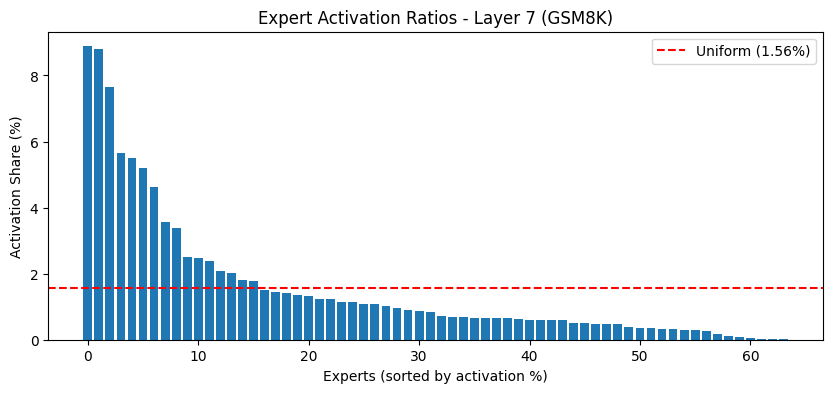

In [8]:
import torch
import matplotlib.pyplot as plt
import os

# Load the telemetry file
file_path = "./telemetry/olmoe_activations_gsm8k.pt"
if not os.path.exists(file_path):
    print("File not found—profiling likely failed.")
else:
    data = torch.load(file_path)
    print(f"✅ File loaded successfully! Size: {os.path.getsize(file_path)/1e6:.2f} MB")
    print(f"   Layers detected: {len(data)} (should be 16)")
    print(f"   Batches per layer: {data[0]['counts'].shape[0]} (≈125 for 1000 samples / batch=8)")
    print(f"   Experts per layer: {data[0]['counts'].shape[1]} (should be 64)\n")

    # Compute aggregate stats across all batches
    for layer_idx in [0, 7, 15]:  # Example: early/mid/late layers
        counts = data[layer_idx]["counts"].sum(dim=0).float()  # Total counts [64]
        total_activations = data[layer_idx]["total"].sum().item()  # Total top-8 selections
        ratios = (counts / total_activations) * 100  # % share per expert

        sorted_ratios, sorted_idx = torch.sort(ratios, descending=True)
        uniform_ratio = 100 / 64  # ~1.56%

        print(f"Layer {layer_idx} Summary:")
        print(f"   Total activations tracked: {total_activations:,}")
        print(f"   Uniform expected ratio: {uniform_ratio:.2f}%")
        print(f"   Top-1 expert share: {sorted_ratios[0]:.2f}%")
        print(f"   Top-8 experts share: {sorted_ratios[:8].sum():.2f}% (>>12.5% uniform = good skew)")
        print(f"   Top-16 experts share: {sorted_ratios[:16].sum():.2f}%\n")

    # Quick visual: Sorted bar plot for one layer (e.g., layer 7—adjust as needed)
    layer_to_plot = 7
    ratios = (data[layer_to_plot]["counts"].sum(0).float() / data[layer_to_plot]["total"].sum()) * 100
    sorted_ratios, _ = torch.sort(ratios, descending=True)

    plt.figure(figsize=(10, 4))
    plt.bar(range(64), sorted_ratios)
    plt.axhline(y=uniform_ratio, color='r', linestyle='--', label=f"Uniform ({uniform_ratio:.2f}%)")
    plt.title(f"Expert Activation Ratios - Layer {layer_to_plot} (GSM8K)")
    plt.xlabel("Experts (sorted by activation %)")
    plt.ylabel("Activation Share (%)")
    plt.legend()
    plt.show()

In [9]:
import torch
import os

# 1. Locate the file
file_path = "./telemetry/olmoe_activations_gsm8k.pt"

print(f"🔍 INSPECTING: {file_path}")

if not os.path.exists(file_path):
    print("❌ File not found! Did you run the profiler?")
else:
    # 2. Load the data
    data = torch.load(file_path)

    # 3. Check Structure
    print(f"✅ File loaded successfully.")
    print(f"   Layers captured: {len(data.keys())} (Should be 16)")

    # 4. Deep Dive into a Random Layer (e.g., Layer 8)
    layer_idx = 8
    layer_data = data[layer_idx]

    counts = layer_data["counts"]      # Shape: [Num_Batches, 64]
    total = layer_data["total"]        # Shape: [Num_Batches]

    print(f"\n📊 LAYER {layer_idx} STATS:")
    print(f"   - Batches processed: {counts.shape[0]}")
    print(f"   - Experts tracked:   {counts.shape[1]}")

    # 5. The "Pulse" Check (Are values non-zero?)
    total_acts = counts.sum().item()
    if total_acts == 0:
        print("⚠️ WARNING: This layer is empty (All zeros). Something is wrong.")
    else:
        print(f"   - Total Expert Activations: {total_acts:,}")

        # Who is the "Hot" expert in this layer?
        # Sum across all batches to get global counts
        global_counts = counts.sum(dim=0)
        top_expert_idx = torch.argmax(global_counts).item()
        top_expert_count = global_counts[top_expert_idx].item()
        usage_percent = (top_expert_count / total_acts) * 100

        print(f"   - 🔥 Hottest Expert: #{top_expert_idx} (Used {usage_percent:.2f}% of the time)")

        # Who is "Cold"?
        zeros = (global_counts == 0).sum().item()
        print(f"   - ❄️ Unused Experts: {zeros}")

print("\nVerdict: If you see 'Hottest Expert' numbers above, it worked perfectly.")

🔍 INSPECTING: ./telemetry/olmoe_activations_gsm8k.pt
✅ File loaded successfully.
   Layers captured: 16 (Should be 16)

📊 LAYER 8 STATS:
   - Batches processed: 32
   - Experts tracked:   64
   - Total Expert Activations: 2,421,696
   - 🔥 Hottest Expert: #45 (Used 8.66% of the time)
   - ❄️ Unused Experts: 0

Verdict: If you see 'Hottest Expert' numbers above, it worked perfectly.
